In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import ast
import json
from hdrh.histogram import HdrHistogram
from matplotlib import colors
from PIL import ImageColor

from sklearn import preprocessing
import re
from libs import read_df

# %#config IPCompleter.greedy=True
# %#matplotlib notebook
# %#matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

POINT_PLOT_DODGE = 0.15
sns.set(font_scale=1.25, style="white")
FIGSIZE = [6, 6]

PALETTE = sns.cubehelix_palette(as_cmap=False, n_colors=3, reverse=False, light=0.7)

In [236]:
print(PALETTE)

[[0.8507598215729224, 0.6322174528970308, 0.6702243543099417], [0.5687505862870377, 0.3322661256969763, 0.5169766917319389], [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]


In [5]:
def shift_value(rgb, shift):
    rgb = ImageColor.getcolor(rgb, "RGB")
    hsv = colors.rgb_to_hsv(rgb)
    hsv[-1] += shift
    return colors.hsv_to_rgb(hsv) / 255


def color_palette(n_colors):
    orig_palette = sns.color_palette("colorblind", as_cmap=True)

    shifts = np.linspace(-0.3, 0.3, n_colors)

    alternate_shifts = shifts.copy()
    alternate_shifts[::2] = shifts[: len(shifts[::2])]
    alternate_shifts[1::2] = shifts[len(shifts[::2]) :]
    palette = [
        shift_value(col, shift) for col, shift in zip(orig_palette, alternate_shifts)
    ]
    return palette

In [131]:
def read_pcm_core(file):
    file_total = file.readlines()

    pos = 9
    interval = 8
    next_block = 17

    # total_df = pd.DataFrame(columns=file_total[pos-1].split(','))
    total_dict = {i: [] for i in file_total[pos - 1].strip().split(",")}
    total_dict_keys = list(total_dict.keys())

    while True:
        for line in range(pos, pos + interval):
            line_contents = file_total[line].strip().split(",")
            
            i = 0
            
            if line_contents == ['']:
                break
                
            for content in line_contents:
                if content == "" or content == '*':
                    break
                    
                total_dict[total_dict_keys[i]].append(float(content))
                i += 1

        pos = pos + next_block
        if pos > len(file_total):
            break

    t = pd.DataFrame(total_dict)

    #return (
    #    t.groupby("Core").mean().transpose()[51.0].to_dict(),
    #    t.groupby("Core").mean().transpose()[52.0].to_dict(),
    #   t.groupby("Core").mean().transpose()[53.0].to_dict(),
    #    t.groupby("Core").mean().transpose()[54.0].to_dict(),
    #
    # print(pd.DataFrame(total).groupby()
    
    return t

In [132]:
measurements_df = pd.DataFrame()
memory = pd.DataFrame()
experiment_labels = [
    "16gbps_balanced",
    "16gbps_unbalanced",
    #"16gbps_unbalanced_2flow"
]

for experiment in experiment_labels:
    output_dir = f"../output/ixia/memory_access/{experiment}"

    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0

        for file in files:
            #none = direc.replace(output_dir, "").split("/")
            #print(direc.replace(output_dir, "").split("/"))
            
            if 'balanced' in file or 'unbalanced' in file:
                with open(direc + "/" + file, "r") as f:
                    core = read_pcm_core(f)
                    
                    exp_id = file.split("_")[-1].strip('csv')
                    core["id"] = exp_id 
                    core["label"] = experiment

                    memory = pd.concat([memory, core])

            if "csv" in file and "Traffic Item" in file and "columns" not in file:
                t = pd.read_csv(direc + "/" + file)

                exp_id = file.split(" ")[0]

                t["id"] = exp_id
                t["label"] = experiment

                # label_string = experiment.split("-")

                measurements_df = pd.concat([measurements_df, t], ignore_index=True)

In [133]:
measurements_df.columns

Index(['Traffic Item', 'Tx Frames', 'Rx Frames', 'Frames Delta', 'Loss %',
       'Tx Frame Rate', 'Rx Frame Rate', 'Tx L1 Rate (bps)', 'Tx Rate (Bps)',
       'Tx Rate (bps)', 'Tx Rate (Kbps)', 'Tx Rate (Mbps)',
       'Avg Delay Variation (ns)', 'Min Delay Variation (ns)',
       'Max Delay Variation (ns)', 'Short Term Avg Delay Variation (ns)',
       'Total Sequence Errors', 'Cut-Through Avg Latency (ns)',
       'Cut-Through Min Latency (ns)', 'Cut-Through Max Latency (ns)',
       'First TimeStamp', 'Last TimeStamp', 'id', 'label'],
      dtype='object')

In [115]:
measurements_df = measurements_df.replace(to_replace="16gbps_balanced", value="Uniform")
measurements_df = measurements_df.replace(
    to_replace="16gbps_unbalanced", value="Non-Uniform"
)
memory = memory.replace(to_replace="16gbps_balanced", value="Uniform")
memory = memory.replace(to_replace="16gbps_unbalanced", value="Non-Uniform")
measurements_df = measurements_df.replace(to_replace="Traffic Item 1", value="TC0")
measurements_df = measurements_df.replace(to_replace="Traffic Item 2", value="TC1")
measurements_df = measurements_df.replace(to_replace="Traffic Item 3", value="TC2")
measurements_df = measurements_df.replace(to_replace="Traffic Item 4", value="TC3")

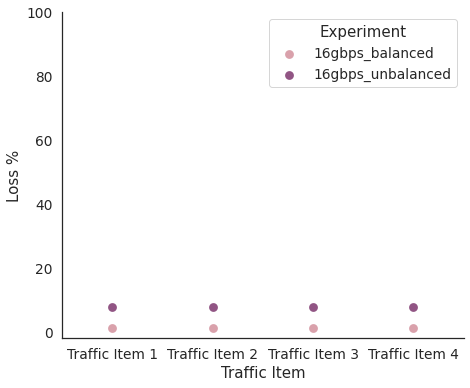

In [140]:
%matplotlib inline
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=[1.2*FIGSIZE[0], FIGSIZE[1]])

fig1 = sns.pointplot(
    data=measurements_df,
    x="Traffic Item",
    y= measurements_df['Loss %'],
    units="id",
    hue='label',
    ax=ax1,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    #ylabel="Average latency (μs)",
    #xlabel="Traffic Class",
    ylim=[-2, 100],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='Experiment', loc='upper right')
sns.despine()

fig.savefig("../output_figures/non_uniform_instance_latency.pdf")


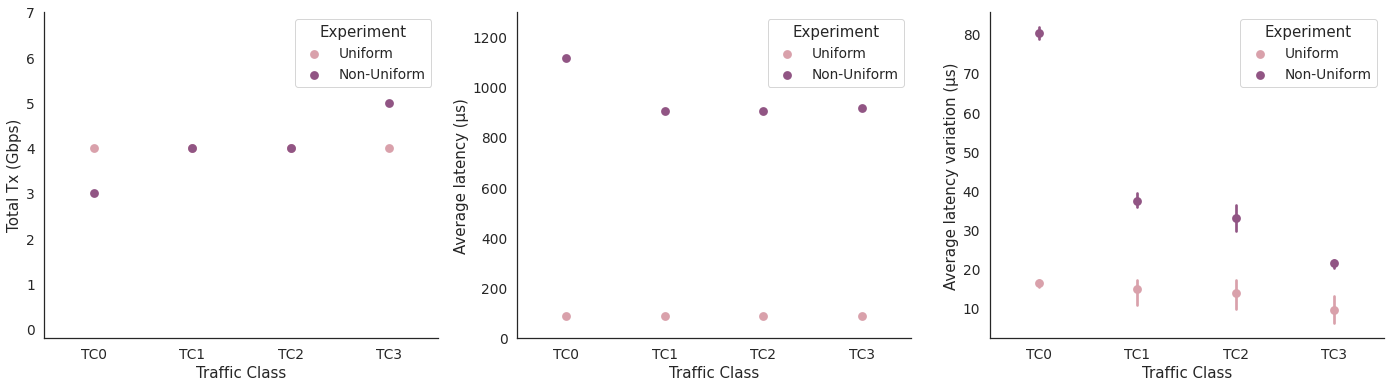

In [159]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=[4*FIGSIZE[0], FIGSIZE[1]])

fig1 = sns.pointplot(
    data=measurements_df,
    x="Traffic Item",
    y= measurements_df['Tx L1 Rate (bps)']/10**9,
    units="id",
    hue='label',
    ax=ax1,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Tx (Gbps)",
    xlabel="Traffic Class",
    ylim=[-0.2, 7],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='Experiment', loc='upper right')
sns.despine()

fig1 = sns.pointplot(
    data=measurements_df,
    x="Traffic Item",
    y= (measurements_df['Cut-Through Avg Latency (ns)']/10**3-24),
    units="id",
    hue='label',
    ax=ax2,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Average latency (μs)",
    xlabel="Traffic Class",
    ylim=[-2, 1300],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax2.legend(title='Experiment', loc='upper right')
sns.despine()


fig1 = sns.pointplot(
    data=measurements_df,
    x="Traffic Item",
    y= measurements_df['Avg Delay Variation (ns)']/10**3,
    units="id",
    hue='label',
    ax=ax3,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="Average latency variation (μs)",
    xlabel="Traffic Class",
  #  ylim=[-0.2, 100],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax3.legend(title='Experiment', loc='upper right')
sns.despine()

# fig.savefig("../output_figures/non_uniform_instance.pdf")

In [137]:
p.groupby(['label', 'Core'])['IPC'].std()

label        Core  
Non-Uniform  HQoS 1    0.157157
             PP        0.121629
Uniform      HQoS 1    0.136698
             PP        0.136108
Name: IPC, dtype: float64

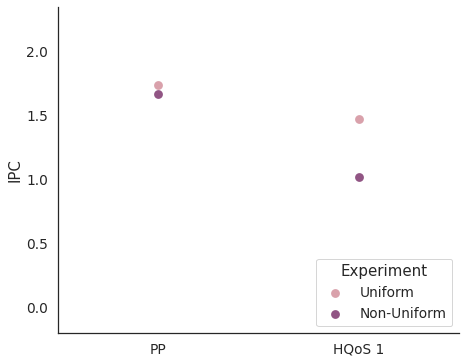

In [130]:
%matplotlib inline
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=[1.2*FIGSIZE[0], FIGSIZE[1]])

p = memory[~memory['IPC'].isin([0.14, 1.99, 2, 2.34, 2.35])]
p = p[p['Core'].isin([37.0, 51.0])]
p = p.replace(to_replace=51.0, value="HQoS 1")
p = p.replace(to_replace=37.0, value="PP")

fig1 = sns.pointplot(
    data=p,
    x="Core",
    y= 'IPC',
    #units="id",
    hue='label',
    ax=ax1,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
)

ax1.set(
    ylabel="IPC",
    xlabel="",
    ylim=[-0.2, 2.35],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
ax1.legend(title='Experiment', loc='lower right')
sns.despine()

fig.savefig("../output_figures/IPC_instance.pdf")

# 50 Gbps

In [153]:
instance_df = pd.DataFrame()
overall_df = pd.DataFrame()
instance_memory = pd.DataFrame()
experiment_labels = [
    "50gbps_balanced_pdv",
    "50gbps_unbalanced_pdv",
]

for experiment in experiment_labels:
    output_dir = f"../output/ixia/memory_access/{experiment}"

    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0

        for file in files:
            #none = direc.replace(output_dir, "").split("/")
            #print(direc.replace(output_dir, "").split("/"))
            
            if 'balanced' in file or 'unbalanced' in file:
                with open(direc + "/" + file, "r") as f:
                    core = read_pcm_core(f)
                    
                    exp_id = file.split("_")[-1].strip('csv')
                    core["id"] = exp_id 
                    core["label"] = experiment

                    instance_memory = pd.concat([instance_memory, core])

            if "csv" in file and "Flow Statistics" in file and "columns" not in file:
                t = pd.read_csv(direc + "/" + file)

                exp_id = file.split(" ")[0]

                t["id"] = exp_id
                t["label"] = experiment

                #label_string = label.split("-")

                instance_df = pd.concat([instance_df, t], ignore_index=True)
                
            if "csv" in file and "Summary Statistics" in file and "columns" not in file:
                t = pd.read_csv(direc + "/" + file)

                exp_id = file.split(" ")[0]

                t["id"] = exp_id
                t["label"] = experiment

                #label_string = label.split("-")

                overall_df = pd.concat([overall_df, t], ignore_index=True)

In [154]:
overall_df['Ethernet II:Destination MAC Address'] = 'All instances'
#new_overall_df = overall_df[['Cut-Through Avg Latency (ns)', 'label']]
instance_df = pd.concat([instance_df, overall_df])
instance_df = instance_df.replace(to_replace="50gbps_balanced_pdv", value="Uniform")
instance_df = instance_df.replace(to_replace="50gbps_unbalanced_pdv", value="Non-Uniform")
instance_memory = instance_memory.replace(to_replace="50gbps_balanced_pdv", value="Uniform")
instance_memory = instance_memory.replace(to_replace="50gbps_unbalanced_pdv", value="Non-Uniform")

instance_df = instance_df.replace(to_replace="Traffic Item 1", value="TC0")
instance_df = instance_df.replace(to_replace="Traffic Item 2", value="TC1")
instance_df = instance_df.replace(to_replace="Traffic Item 3", value="TC2")
instance_df = instance_df.replace(to_replace="Traffic Item 4", value="TC3")

instance_df = instance_df.replace(to_replace="00:00:00:01:00:01", value="HQoS 1")
instance_df = instance_df.replace(to_replace="00:00:00:01:00:03", value="HQoS 2")
instance_df = instance_df.replace(to_replace="00:00:00:01:00:05", value="HQoS 3")
instance_df = instance_df.replace(to_replace="00:00:00:01:00:07", value="HQoS 4")

In [155]:
t = instance_df.groupby(["label", "Ethernet II:Destination MAC Address", "Traffic Item"])[
    "Tx L1 Rate (bps)"
].mean().reset_index().groupby(["label", "Ethernet II:Destination MAC Address"]).sum()
t = t.reset_index()

In [156]:
instance_df.groupby('label')['Cut-Through Avg Latency (ns)'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Non-Uniform,85.0,356793.705882,329187.315408,151502.0,152733.0,172596.0,411131.0,989472.0
Uniform,85.0,152069.847059,985.565544,150050.0,151390.0,151836.0,152870.0,154310.0


In [157]:
instance_df.groupby('Ethernet II:Destination MAC Address')['Avg Delay Variation (ns)'].describe().unstack().mean()

15287.13371052008

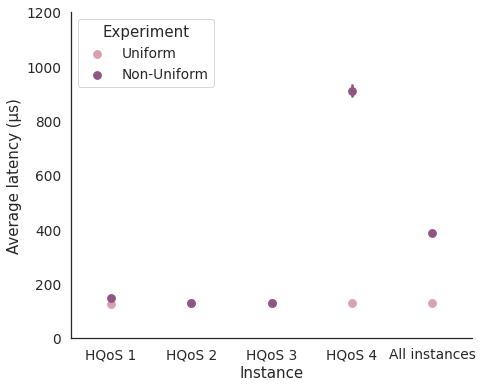

In [160]:
%matplotlib inline
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=[1.2*FIGSIZE[0], FIGSIZE[1]])

fig1 = sns.pointplot(
    data=instance_df,
    x="Ethernet II:Destination MAC Address",
    y=(instance_df['Cut-Through Avg Latency (ns)']/10**3-24),
    units="id",
    hue='label',
    ax=ax1,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Average latency (μs)",
    xlabel="Instance",
    ylim=[-0.2, 1200],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
#ax1.legend(title='VNF', loc='lower left')
ax1.legend(title='Experiment', loc='upper left')
sns.despine()
# fig.savefig("../output_figures/multiple_instances_delay.pdf")

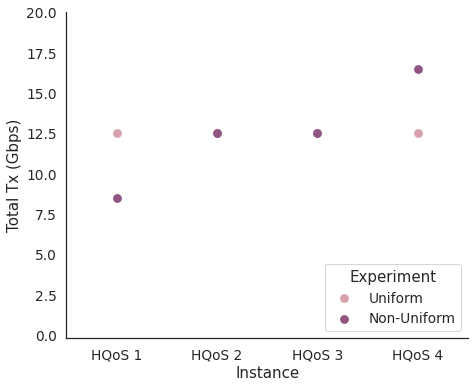

In [145]:
%matplotlib inline
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=[1.2*FIGSIZE[0], FIGSIZE[1]])

fig1 = sns.pointplot(
    data=t,
    x="Ethernet II:Destination MAC Address",
   # x="Traffic Item",
    y= t['Tx L1 Rate (bps)']/10**9,
    #units="id",
    hue='label',
    ax=ax1,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    hue_order = ['Uniform', 'Non-Uniform'],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Tx (Gbps)",
    xlabel="Instance",
    ylim=[-0.2, 20],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
#ax1.legend(title='VNF', loc='lower left')
ax1.legend(title='Experiment', loc='lower right')
sns.despine()

fig1 = sns.pointplot(
    data=instance_df,
    x="Ethernet II:Destination MAC Address",
    y= instance_df['Cut-Through Avg Latency (ns)']/10**3,
    units="id",
    hue='label',
    ax=ax2,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Average latency (μs)",
    xlabel="Instance",
    ylim=[-0.2, 1200],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
#ax1.legend(title='VNF', loc='lower left')
ax2.legend(title='Experiment', loc='upper left')

sns.despine()

fig1 = sns.pointplot(
    data=instance_df,
    x="Ethernet II:Destination MAC Address",
    y= instance_df['Avg Delay Variation (ns)']/10**3,
    units="id",
    hue='label',
    ax=ax3,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="Average latency variation (μs)",
    xlabel="Instance",
    ylim=[-0.2, 30],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
#ax1.legend(title='VNF', loc='lower left')
ax3.legend(title='Experiment', loc='upper right')

sns.despine()

fig.savefig("../output_figures/multiple_instances.pdf")

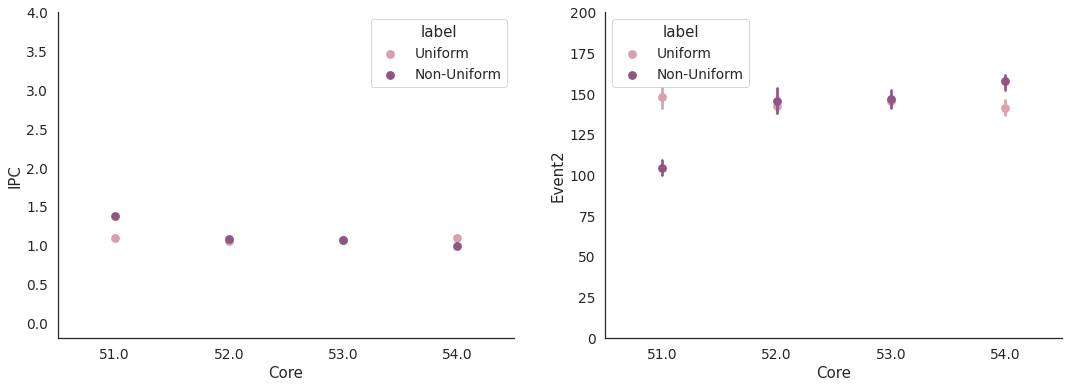

In [28]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[3*FIGSIZE[0], FIGSIZE[1]])

p = instance_memory[~instance_memory['IPC'].isin([0.14, 2.34, 2.35])]
p = p[p['Core'].isin([51.0, 52.0, 53.0, 54.0])]

fig1 = sns.pointplot(
    data=p,
    x="Core",
    y= 'IPC',
    units="id",
    hue='label',
    ax=ax1,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
  #  ylabel="Average latency (μs)",
    #xlabel="",
    ylim=[-0.2, 4],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
sns.despine()

fig2 = sns.pointplot(
    data=p,
    x="Core",
    #y= p['Event0'],
    y= p['Event2']/10**6,
    units="id",
    hue='label',
    ax=ax2,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)
ax2.set(
    #ylabel="Average latency (μs)",
    #xlabel="",
    ylim=[-0.5, 200],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)

sns.despine()

In [141]:
baseline_df = pd.DataFrame()
memory = pd.DataFrame()
experiment_labels = [
    "baseline",
]

for experiment in experiment_labels:
    output_dir = f"../output/ixia/{experiment}"

    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0

        for file in files:
            none, exp, label = direc.replace(output_dir, "").split("/")
            #print(direc.replace(output_dir, "").split("/"))
            
            if "csv" in file and "Test Summary" in file and "columns" not in file:
                t = pd.read_csv(direc + "/" + file)

                exp_id = file.split(" ")[0]

                t["id"] = exp_id
                t["label"] = int(label.strip('gbps'))
                t["exp"] = exp

                # label_string = experiment.split("-")

                baseline_df = pd.concat([baseline_df, t], ignore_index=True)

In [143]:
baseline_df.columns

Index(['Tx Frames Count', 'Rx Frames Count', 'Tx Frame Rate', 'Rx Frame Rate',
       'Tx L1 Rate (bps)', 'Rx L1 Rate (bps)', 'Tx L2 Throughput (Bps)',
       'Rx L2 Throughput (Bps)', 'Tx L2 Throughput (bps)',
       'Rx L2 Throughput (bps)', 'Tx L2 Throughput (Kbps)',
       'Rx L2 Throughput (Kbps)', 'Tx L2 Throughput (Mbps)',
       'Rx L2 Throughput (Mbps)', 'Cut-Through Avg Latency (ns)',
       'Cut-Through Min Latency (ns)', 'Cut-Through Max Latency (ns)', 'id',
       'label', 'exp'],
      dtype='object')

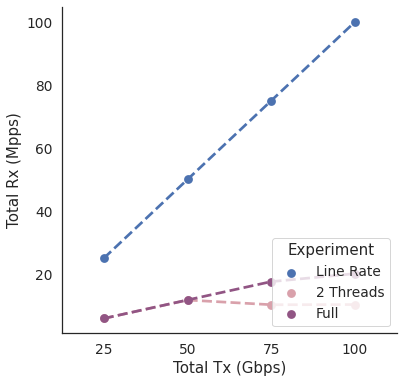

In [157]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[FIGSIZE[0], FIGSIZE[1]])

ideal_df = pd.DataFrame([(i/(512/8),i,'Line Rate') for i in range(25, 125, 25)])

sns.pointplot(
    x = ideal_df[0],
    y = ideal_df[1],
    hue = ideal_df[2],
    join=True,
    linestyles="--",
)

fig1 = sns.pointplot(
    data=baseline_df,
    x='label',
    y=baseline_df["Rx Frame Rate"]/10**6,
    units="id",
    hue='exp',
    ax=ax1,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Total Tx (Gbps)",
   # ylim=[-0.2, 105],
   # title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='Experiment', loc='lower right')

sns.despine()

# fig.savefig("../output_figures/suboptimal_util.pdf")

In [185]:
batch = pd.DataFrame()
flow = pd.DataFrame()
experiment_labels = [
    "kundel",
]

for experiment in experiment_labels:
    output_dir = f"../output/ixia/{experiment}"

    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0

        for file in files:
            #print(direc.replace(output_dir, "").split("/"))
            none, label = direc.replace(output_dir, "").split("/")
            #
            
            if "csv" in file and "Test Summary" in file and "columns" not in file:
                t = pd.read_csv(direc + "/" + file)

                exp_id = file.split(" ")[0]

                t["id"] = exp_id
                t["label"] = label

                # label_string = experiment.split("-")

                batch = pd.concat([batch, t], ignore_index=True)
            
            if "csv" in file and "Flow Statistics" in file and "columns" not in file:
                t = pd.read_csv(direc + "/" + file)

                exp_id = file.split(" ")[0]
                
                t["id"] = exp_id
                t["label"] = label
                # t["exp"] = int(exp)

                #label_string = label.split("-")

                flow = pd.concat([flow, t], ignore_index=True)

In [212]:
print(flow.columns)
flow[flow['Traffic Item'] == 'Traffic Item 1'].groupby("label")[
    [
        "Tx Frame Rate",
    ]   
].mean()#/10**3-24

Index(['Tx Port', 'Rx Port', 'Traffic Item',
       'Ethernet II:Destination MAC Address', 'Tx Frames', 'Rx Frames',
       'Frames Delta', 'Loss %', 'Tx Frame Rate', 'Rx Frame Rate',
       'Tx L1 Rate (bps)', 'Tx Rate (Bps)', 'Tx Rate (bps)', 'Tx Rate (Kbps)',
       'Tx Rate (Mbps)', 'Avg Delay Variation (ns)',
       'Min Delay Variation (ns)', 'Max Delay Variation (ns)',
       'Short Term Avg Delay Variation (ns)', 'Total Sequence Errors',
       'Last Sequence Number', 'Cut-Through Avg Latency (ns)',
       'Cut-Through Min Latency (ns)', 'Cut-Through Max Latency (ns)',
       'First TimeStamp', 'Last TimeStamp', 'id', 'label'],
      dtype='object')


,Tx Frame Rate
label,
0,0.0
32,0.0
64,0.0
128,0.0
256,0.0


In [189]:
batch = pd.DataFrame()
flow = pd.DataFrame()
experiment_labels = [
    "batch_pdv",
]

for experiment in experiment_labels:
    output_dir = f"../output/ixia/{experiment}"

    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0

        for file in files:
            #print(direc.replace(output_dir, "").split("/"))
            none, label = direc.replace(output_dir, "").split("/")
            #
            
            if "csv" in file and "Test Summary" in file and "columns" not in file:
                t = pd.read_csv(direc + "/" + file)

                exp_id = file.split(" ")[0]

                t["id"] = exp_id
                t["label"] = label

                # label_string = experiment.split("-")

                batch = pd.concat([batch, t], ignore_index=True)
            
            if "csv" in file and "Flow Statistics" in file and "columns" not in file:
                t = pd.read_csv(direc + "/" + file)

                exp_id = file.split(" ")[0]
                
                t["id"] = exp_id
                t["label"] = int(label)
                # t["exp"] = int(exp)

                #label_string = label.split("-")

                flow = pd.concat([flow, t], ignore_index=True)

In [190]:
flow.columns

Index(['Tx Port', 'Rx Port', 'Traffic Item',
       'Ethernet II:Destination MAC Address', 'Tx Frames', 'Rx Frames',
       'Frames Delta', 'Loss %', 'Tx Frame Rate', 'Rx Frame Rate',
       'Tx L1 Rate (bps)', 'Tx Rate (Bps)', 'Tx Rate (bps)', 'Tx Rate (Kbps)',
       'Tx Rate (Mbps)', 'Avg Delay Variation (ns)',
       'Min Delay Variation (ns)', 'Max Delay Variation (ns)',
       'Short Term Avg Delay Variation (ns)', 'Total Sequence Errors',
       'Last Sequence Number', 'Cut-Through Avg Latency (ns)',
       'Cut-Through Min Latency (ns)', 'Cut-Through Max Latency (ns)',
       'First TimeStamp', 'Last TimeStamp', 'id', 'label'],
      dtype='object')

In [219]:
flow[flow['Traffic Item'] == 'Traffic Item 1'].groupby('label')['Cut-Through Max Latency (ns)'].describe()/10**3

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,0.005,155.0048,11.427130,144.285,144.712,153.910,160.772,171.345
32,0.005,849.9254,1124.918135,115.855,339.130,412.175,539.112,2843.355
64,0.005,698.7198,475.850162,148.155,258.632,846.875,993.312,1246.625
128,0.005,426.0314,179.552426,142.070,407.472,446.845,504.175,629.595
256,0.005,525.8238,618.493761,180.675,183.817,258.567,383.690,1622.370


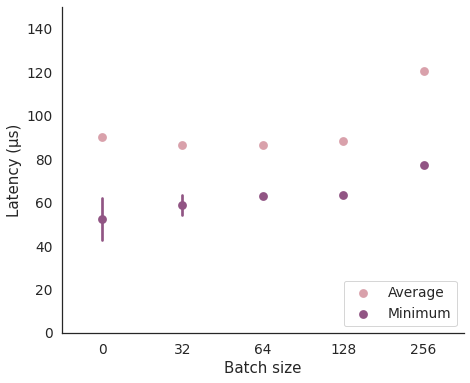

In [230]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[1.2*FIGSIZE[0], FIGSIZE[1]])

flow_melted = pd.melt(
    flow[flow['Traffic Item'] == 'Traffic Item 1'],
    id_vars = ['label', 'id'],
    value_vars =[
        'Cut-Through Avg Latency (ns)',
        'Cut-Through Min Latency (ns)',
        #Cut-Through Max Latency (ns)',
    ]
)
flow_melted = flow_melted.replace(to_replace="Cut-Through Avg Latency (ns)", value="Average")
flow_melted = flow_melted.replace(to_replace="Cut-Through Min Latency (ns)", value="Minimum")

fig1 = sns.pointplot(
    data=flow_melted,
    x='label',
    y=flow_melted["value"]/10**3,
    units="id",
    hue='variable',
    ax=ax1,
    palette = PALETTE,
    ci=95,
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Latency (μs)",
    xlabel="Batch size",
    ylim=[-0.2, 150],
   #title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='', loc='lower right')

sns.despine()

# fig.savefig("../output_figures/min_avg_latency_batch.pdf")

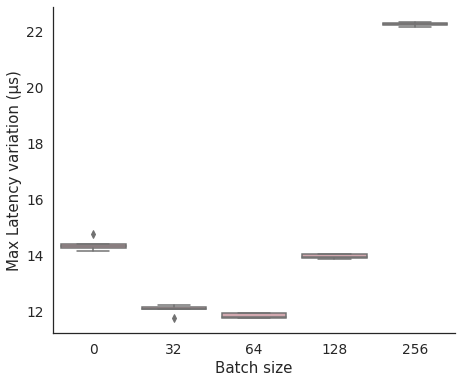

In [241]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[1.2*FIGSIZE[0], FIGSIZE[1]])

flow_melted = pd.melt(
    flow[flow['Traffic Item'] == 'Traffic Item 1'],
    id_vars = ['label', 'id'],
    value_vars =[
        'Avg Delay Variation (ns)',
        #'Max Delay Variation (ns)',
    ]
)
flow_melted = flow_melted.replace(to_replace="Avg Delay Variation (ns)", value="Average")
flow_melted = flow_melted.replace(to_replace="Min Delay Variation (ns)", value="Minimum")


fig1 = sns.boxplot(
    data=flow_melted,
    x='label',
    y=flow_melted["value"]/10**3,
    #units="id",
    #hue='variable',
    ax=ax1,
    color = [0.8507598215729224, 0.6322174528970308, 0.6702243543099417],
    
    #palette = PALETTE,
    #ci=95,
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=False,
    #linestyles="--",
    #linewidth=0.005,
    # hue_order = ['1stream],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Max Latency variation (μs)",
    xlabel="Batch size",
    #ylim=[-0.2, 60],
   #title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
# ax1.legend(title='', loc='upper left')

sns.despine()

fig.savefig("../output_figures/max_latency_variation_batch.pdf")